In [1]:
%load_ext autoreload
%autoreload 2

## Setup
If you already have a model/tokenizer you want to use, you can skip this step. 
Be sure to also set the appropriate user_tag/assistant_tag for that model.

In [2]:
%%capture
# The quantized model used here requires some extra libraries. 
import sys
!{sys.executable} -m pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu121
!{sys.executable} -m pip install optimum>=1.12.0
!{sys.executable} -m pip install auto-gptq==0.6.0
!{sys.executable} -m pip install accelerate

In [ ]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/workspace/cache/' # change or comment out as desired 
from transformers import AutoModelForCausalLM, AutoTokenizer

def load_model(model_name_or_path, revision, device):
    model = AutoModelForCausalLM.from_pretrained(
        model_name_or_path, device_map=device, revision=revision, trust_remote_code=False)
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True, padding_side="left")
    tokenizer.pad_token_id = 0
    return model, tokenizer

device = 'cuda:0'
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ"
revision = 'gptq-4bit-32g-actorder_True'
user_tag = "[INST] "
assistant_tag = " [/INST]"

model, tokenizer = load_model(model_name_or_path, revision, device)

config.json:   0%|          | 0.00/962 [00:00<?, ?B/s]

2024-04-15 17:26:14.716251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 17:26:14.716315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 17:26:14.717591: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 17:26:14.724736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 17:26:15.676608: W tensorflow/compiler/tf2

model.safetensors:   0%|          | 0.00/4.57G [00:00<?, ?B/s]

## Train extractor

In [ ]:
from lmdoctor.doctor import Doctor
extraction_target = 'honesty'
probe_type = 'pca'
doc = Doctor(model, tokenizer, user_tag, assistant_tag, extraction_target=extraction_target, probe_type=probe_type, device=device)
doc.extract(n_train_pairs=128, n_dev_pairs=64, n_test_pairs=32)

In [ ]:
doc.statement_pairs['train'][:1]

## Get my QA example

In [5]:
import pandas as pd
qa = pd.read_csv('myqa/hallucination_prompts.csv')
qa.head(2)

,Hallucination Question,Hallucination Answer,Factual Question,Factual Answer
0,What are the primary ingredients in a Grinmoss...,The primary ingredients in a Grinmoss Potion are,What are the primary ingredients in a Caesar S...,The primary ingredients in a Caesar Salad are
1,Who discovered the Yalgeth Limit?,The Yalgeth Limit was discovered by,Who discovered penicillin?,Penicillin was discovered by


In [298]:
# prompt = qa['Hallucination Question'].iloc[5]
# prompt = qa['Factual Question'].iloc[5]
# prompt = 'Describe the plot of The Catcher in the Rye.'
prompt = 'Who first articulated the theory of relativity?'

print(prompt)
max_new_tokens = 30
output = doc.generate(prompt, max_new_tokens=max_new_tokens, do_sample=False, gen_only=True, return_projections=True)
output['text']

Who first articulated the theory of relativity?
['<s>', '▁[', 'INST', ']', '▁Who', '▁first', '▁artic', 'ulated', '▁the', '▁theory', '▁of', '▁rel', 'ativity', '?', '▁[', '/', 'INST', ']', '▁The', '▁theory', '▁of', '▁rel', 'ativity', '▁was', '▁first', '▁artic', 'ulated', '▁by', '▁Albert', '▁Einstein', '.', '</s>']


''

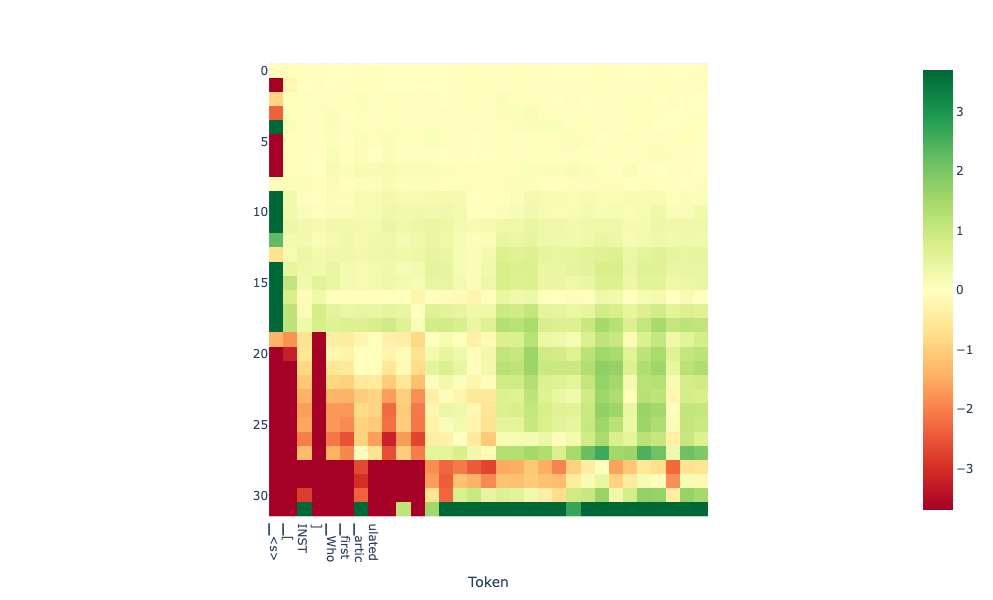

In [276]:
tokens = tokenizer.tokenize(output['text'])
doc.plot_projection_heatmap(output['projections'], tokens, lastn_tokens_to_plot=None, saturate_at='auto')

In [206]:
output['projections'].shape

torch.Size([32, 31])

In [215]:
len(tokens)

30

In [211]:
output['text']

'[INST] Who first articulated the theory of relativity? [/INST] The theory of relativity was first articulated by Albert Einstein.'

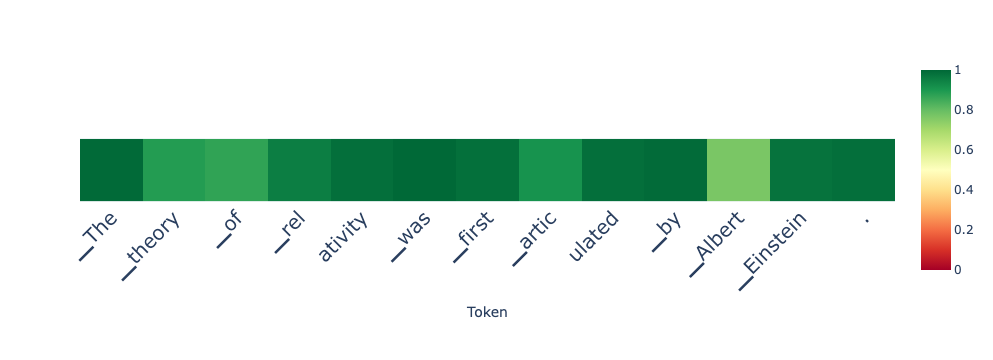

In [184]:
scores_per_token = doc.detect(output['projections'], aggregation_method='auto')
doc.plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens, detection_method='classifier')

## Get distributions of scores across whole dataset

In [174]:
import numpy as np

def _get_scores(doc, prompts, max_new_tokens=30):
    output = doc.generate(prompts, max_new_tokens=max_new_tokens, do_sample=False, gen_only=True, return_projections=True)
    all_scores_per_token = []
    for projs in output['projections']:
        scores_per_token = doc.detect(projs, aggregation_method='auto')[0]
        all_scores_per_token.append(list(scores_per_token))
    return all_scores_per_token, output['text']

batch_size = 2
hallucination_scores = []
hallucination_texts = []
factual_scores = []
factual_texts = []
# hallucination_questions = qa['Hallucination Question'].tolist()
hallucination_questions = qa['Factual Question'].iloc[4:6].tolist()
# factual_questions = qa['Factual Question'].tolist()
factual_questions = qa['Factual Question'].iloc[4:6].tolist()


for i in range(0, len(hallucination_questions), batch_size):
# for i in range(0, 8, batch_size):
    print(i)
    these_hall_scores, these_hall_texts = _get_scores(doc, hallucination_questions[i:i+batch_size])
    hallucination_scores.extend(these_hall_scores)
    hallucination_texts.extend(these_hall_texts)
    these_fac_scores, these_fac_texts = _get_scores(doc, factual_questions[i:i+batch_size])
    factual_scores.extend(these_fac_scores)
    factual_texts.extend(these_fac_texts)

0


In [175]:
factual_questions

['Describe the plot of The Catcher in the Rye.',
 'Who first articulated the theory of relativity?']

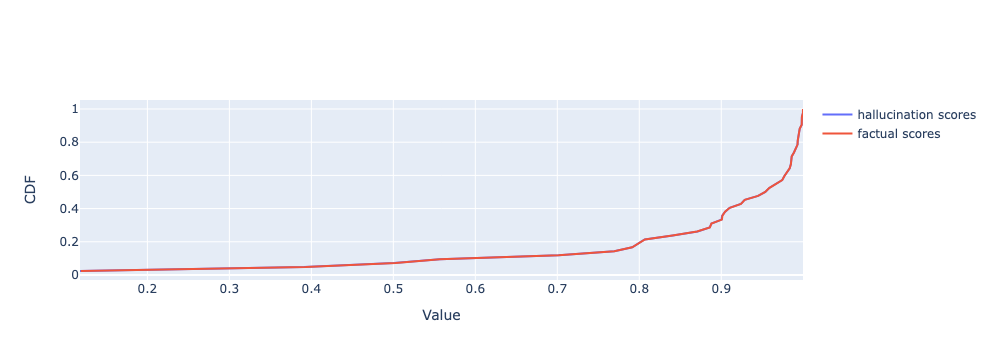

In [176]:
import numpy as np
import plotly.graph_objects as go

arr1 = [item for sublist in hallucination_scores for item in sublist]
arr2 =  [item for sublist in factual_scores for item in sublist]
arr1_sorted = np.sort(arr1)
arr2_sorted = np.sort(arr2)
cdf1 = np.arange(1, len(arr1) + 1) / len(arr1)
cdf2 = np.arange(1, len(arr2) + 1) / len(arr2)

fig = go.Figure()
fig.add_trace(go.Scatter(x=arr1_sorted, y=cdf1, mode='lines', name='hallucination scores'))
fig.add_trace(go.Scatter(x=arr2_sorted, y=cdf2, mode='lines', name='factual scores'))
fig.update_layout(xaxis_title='Value', yaxis_title='CDF')
fig.show()

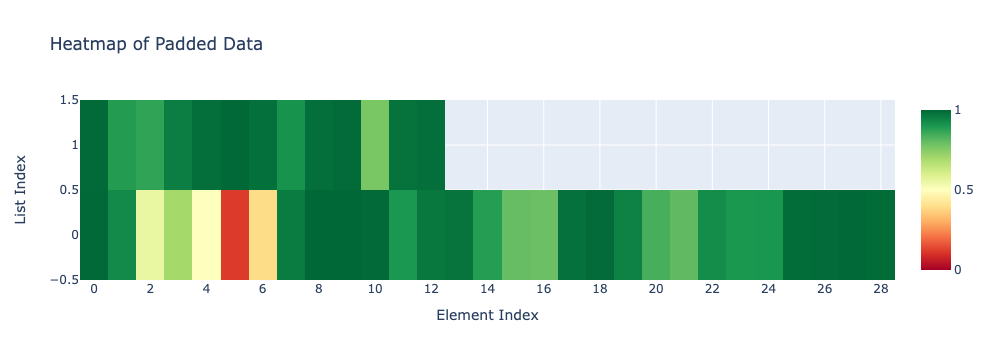

In [177]:
import plotly.graph_objects as go
import numpy as np


# data = hallucination_scores
data = factual_scores

# Define the maximum number of elements in each sublist
n_to_plot = 32
max_length = 29
# Pad data
padded_data = [sublist + [np.nan] * (max_length - len(sublist)) for sublist in data[:n_to_plot]]


# Create a heatmap
fig = go.Figure(data=go.Heatmap(
    z=padded_data,
    # x=list(range(1, max_length + 1)),  # Column headers as position indices
    # y=['{}'.format(i+1) for i in range(len(padded_data))],  # Row labels
    # colorscale='Viridis',  # Color scale
    colorscale='RdYlGn',
    zmin=0,  # Minimum of color scale
    zmax=1,  # Maximum of color scale (adjust according to your data range)
    hoverongaps=False,  # Hover info for gaps
    showscale=True
))

# Update layout
fig.update_layout(
    title='Heatmap of Padded Data',
    xaxis_title='Element Index',
    yaxis_title='List Index',
    xaxis_nticks=max_length
)

# Show the figure
fig.show()


In [281]:
import torch

prompts = ['[INST] Describe the plot of The Catcher in the Rye. [/INST]',
           '[INST] Who first articulated the theory of relativity? [/INST]']

model_inputs = tokenizer(prompts, return_tensors='pt', padding=True).to('cuda:0')

with torch.no_grad():
    output = model.generate(**model_inputs, output_hidden_states=True, return_dict_in_generate=True, max_new_tokens=30)

In [282]:
texts = tokenizer.batch_decode(output.sequences, skip_special_tokens=True, clean_up_tokenization_spaces=False)
texts

['[INST] Describe the plot of The Catcher in the Rye. [/INST] The Catcher in the Rye is a novel by J.D. Salinger, published in 1951, that follows the',
 '[INST] Who first articulated the theory of relativity? [/INST] The theory of relativity was first articulated by Albert Einstein.']

In [283]:
len(tokenizer.tokenize(texts[1]))

30

In [284]:
def _get_start_end_idxs(tensor_data):
    first_non_zero_indices = []
    last_non_zero_indices = []
    for data in tensor_data:
        data_np = data.cpu().numpy()
        first_non_zero_idx = (data_np != 0).argmax()
        first_non_zero_indices.append(first_non_zero_idx)
        reversed_data = data_np[::-1]
        last_non_zero_idx = len(data_np) - (reversed_data != 0).argmax()
        last_non_zero_indices.append(last_non_zero_idx)
    return first_non_zero_indices, last_non_zero_indices

In [285]:
sequences = output['sequences']
sequences

tensor([[    1,   733, 16289, 28793, 27984,   272,  9242,   302,   415,   334,
           855,   263,   297,   272,   399,  7187, 28723,   733, 28748, 16289,
         28793,   415,   334,   855,   263,   297,   272,   399,  7187,   349,
           264,  7092,   486,   475, 28723, 28757, 28723,  4902,  4576, 28725,
          4775,   297, 28705, 28740, 28774, 28782, 28740, 28725,   369,  6104,
           272],
        [    0,     0,     0,     1,   733, 16289, 28793,  6526,   907, 22187,
          6432,   272,  5742,   302,  1016, 28283, 28804,   733, 28748, 16289,
         28793,   415,  5742,   302,  1016, 28283,   403,   907, 22187,  6432,
           486, 12560, 25721, 28723,     2,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]], device='cuda:0')

In [286]:
start_prompt_idxs, end_gen_idxs = _get_start_end_idxs(output.sequences)
start_prompt_idxs, end_gen_idxs


([0, 3], [51, 35])

In [287]:
start_gen_idx = model_inputs.input_ids.shape[1]
# gen only
for i in range(2):
    print(sequences[i][start_gen_idx:end_gen_idxs[i]])
    
# all 
for i in range(2):
    print(sequences[i][start_prompt_idxs[i]:end_gen_idxs[i]])

tensor([  415,   334,   855,   263,   297,   272,   399,  7187,   349,   264,
         7092,   486,   475, 28723, 28757, 28723,  4902,  4576, 28725,  4775,
          297, 28705, 28740, 28774, 28782, 28740, 28725,   369,  6104,   272],
       device='cuda:0')
tensor([  415,  5742,   302,  1016, 28283,   403,   907, 22187,  6432,   486,
        12560, 25721, 28723,     2], device='cuda:0')
tensor([    1,   733, 16289, 28793, 27984,   272,  9242,   302,   415,   334,
          855,   263,   297,   272,   399,  7187, 28723,   733, 28748, 16289,
        28793,   415,   334,   855,   263,   297,   272,   399,  7187,   349,
          264,  7092,   486,   475, 28723, 28757, 28723,  4902,  4576, 28725,
         4775,   297, 28705, 28740, 28774, 28782, 28740, 28725,   369,  6104,
          272], device='cuda:0')
tensor([    1,   733, 16289, 28793,  6526,   907, 22187,  6432,   272,  5742,
          302,  1016, 28283, 28804,   733, 28748, 16289, 28793,   415,  5742,
          302,  1016, 28283,  

In [288]:
end_gen_idxs

[51, 35]

In [289]:
start_gen_idx

21

In [296]:
tokenizer.convert_ids_to_tokens(output['sequences'][1])

['<unk>',
 '<unk>',
 '<unk>',
 '<s>',
 '▁[',
 'INST',
 ']',
 '▁Who',
 '▁first',
 '▁artic',
 'ulated',
 '▁the',
 '▁theory',
 '▁of',
 '▁rel',
 'ativity',
 '?',
 '▁[',
 '/',
 'INST',
 ']',
 '▁The',
 '▁theory',
 '▁of',
 '▁rel',
 'ativity',
 '▁was',
 '▁first',
 '▁artic',
 'ulated',
 '▁by',
 '▁Albert',
 '▁Einstein',
 '.',
 '</s>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

In [295]:
output['sequences'][1]

tensor([    0,     0,     0,     1,   733, 16289, 28793,  6526,   907, 22187,
         6432,   272,  5742,   302,  1016, 28283, 28804,   733, 28748, 16289,
        28793,   415,  5742,   302,  1016, 28283,   403,   907, 22187,  6432,
          486, 12560, 25721, 28723,     2,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0], device='cuda:0')